In [15]:
import pandas as pd
import requests
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout
%matplotlib inline

In [16]:
def seltypeid(tid):
  global typeid
  typeid = tid['new']

In [17]:
def go(g):
  global dfsdesc, dfall, dfts, dfpr
  
  url = 'https://fits.geonet.org.nz/site?typeID='+typeid
  r = requests.get(url)
  jdata = r.json()
  features = jdata['features']
    
  dfsite = pd.DataFrame()
  for i, val in enumerate(features):
    geometry = val['geometry']
    properties = val['properties']
    siteID = properties['siteID']
    networkID = properties['networkID']
    name = properties['name']
    dfsite = dfsite.append({'networkID': networkID, 'siteID': siteID, 'name': name}, ignore_index=True)

  names = ['dt', 'obs', 'err']
  dfts = pd.DataFrame()
  for site, network, name in zip(dfsite['siteID'], dfsite['networkID'], dfsite['name']):
    site = site.encode('ascii','ignore')
    network = network.encode('ascii','ignore')
    name = name.encode('ascii', 'ignore')
    url= 'https://fits.geonet.org.nz/observation?typeID='+typeid+'&siteID='+site+'&networkID='+network
    df = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
    df['siteID'] = site
    df['networkID'] = network
    df['name'] = name
    dfts = dfts.append(df, ignore_index=True)
    
  flierprops = dict(marker='o', markerfacecolor='black', markersize=2)
  whiskerprops = dict(linestyle='-')
  bp = dfts.boxplot(column='obs', by='siteID', figsize=(30,10), rot=90, showmeans=True, whis=[5,95], flierprops=flierprops, whiskerprops=whiskerprops)
  bp.get_figure().suptitle("") #get rid of automatic boxplot sub-title
  bp.set_ylabel("Concentration (mg/L)")
  bp.set_xlabel("siteID")
  bp.set_yscale('log')
  bp.set_title(typeid+' concentration by siteID (whisker=5%-95%)')
  fig = bp.get_figure()
  fig.savefig(typeid+'.png', dpi=200)
    
  #print file
  dfdesc = dfts['obs'].groupby(dfts['siteID']).describe()
  dfname = dfts[['siteID','name']]
  dfn = dfname.drop_duplicates()
  dfp = dfdesc.reset_index(level=0)
  dfpr = pd.merge(dfn, dfp, on=['siteID'])
  dfpr.sort_values(by='siteID',inplace=True)
  dfpr.to_csv(typeid+'.csv', index=False)

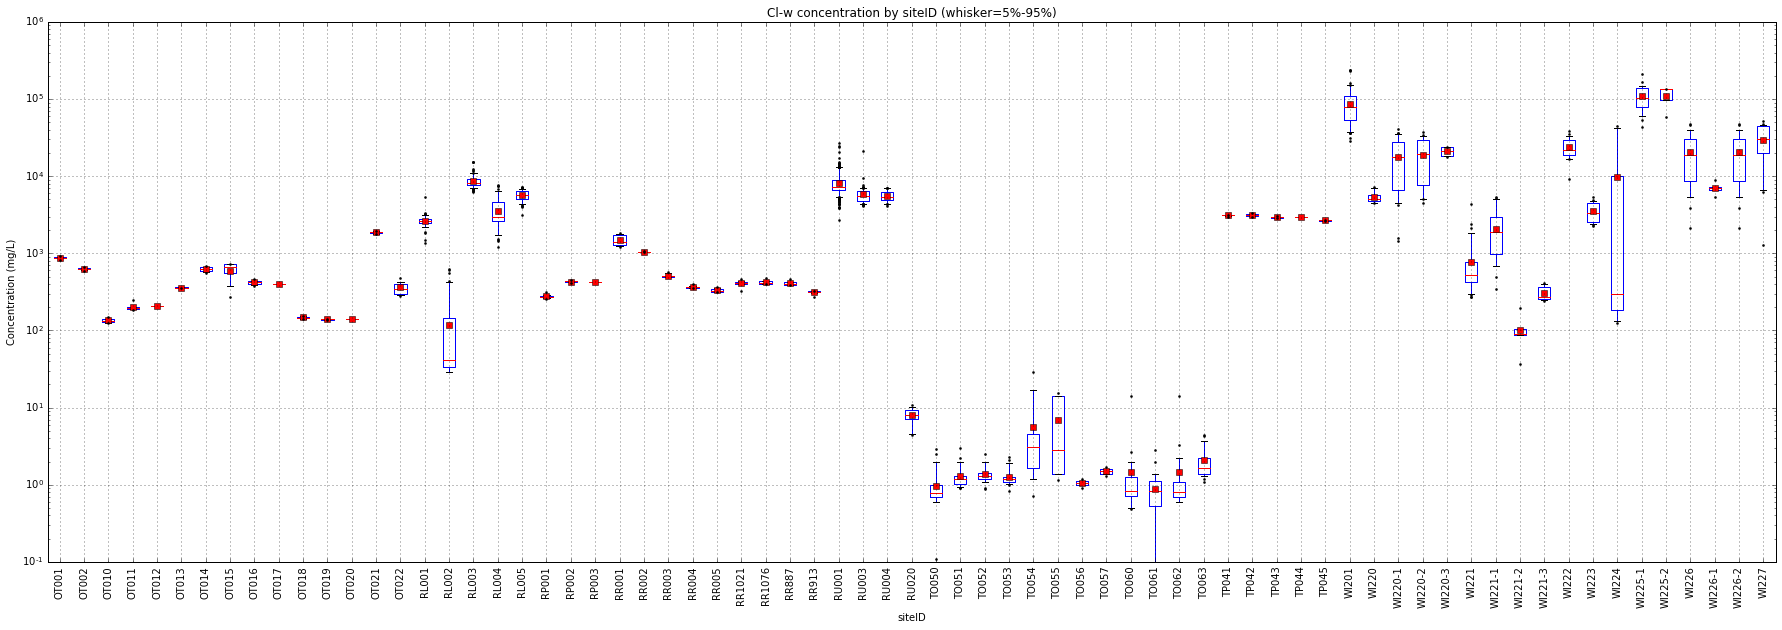

In [18]:
tid = widgets.Text(
    value='',
    placeholder='',
    description='TypeID to plot:',
    disabled=False
)
tid.observe(seltypeid, names='value')

g=widgets.Button(
    description='Retrieve and plot',
    disabled=False,
    button_style='success',
    tooltip='Retrieve data and plotting')
g.on_click(go)

widgets.HBox([tid, g])